In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# Reading in temps data
temps = pd.read_excel("original data/Temps Data full.xls", sheet_name = None)
frames = [df for sheet, df in temps.items()]
temps_raw = pd.concat(frames)

In [ ]:
temps_raw = temps_raw[["BEGIN_DATE_GMT","END_DATE_GMT","SOURCE_DATETIME","SOURCE_TIMEZONE","NRG_STREAM_NAME","TEMP_CELSIUS"]]
pd.unique(temps_raw["NRG_STREAM_NAME"])

In [ ]:
yyc_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == "EC - Calgary Temp"]

fort_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == "EC - Fort McMurray Temp"]

lethbridge_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == 'EC - Lethbridge Temp']

edmonton_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == 'EC - Edmonton Temp']

In [65]:
#Consider the outlier an NA
lb_outlier_index = lethbridge_temp_raw [lethbridge_temp_raw["TEMP_CELSIUS"] > 40].index
lethbridge_temp_raw.at[lb_outlier_index, "TEMP_CELSIUS"] = None

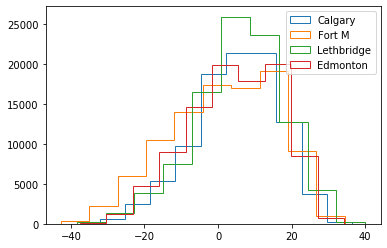

In [66]:
bins = np.linspace(-60, 40, 60)

plt.hist(yyc_temp_raw["TEMP_CELSIUS"], histtype= 'step', label='Calgary')
plt.hist(fort_temp_raw["TEMP_CELSIUS"],  histtype= 'step', label='Fort M')
plt.hist(lethbridge_temp_raw["TEMP_CELSIUS"],  histtype= 'step', label='Lethbridge')
plt.hist(edmonton_temp_raw["TEMP_CELSIUS"], 
         histtype= 'step', label='Edmonton')
plt.legend(loc='upper right')
plt.show()

In [ ]:
full_time = pd.DataFrame( pd.date_range(start='2010-01-01 07:00:00', end = '2021-01-05 07:00:00', freq='H'), 
                         columns = ["FULL_BEGIN_DATE_GMT"] )

def merge_full_time(df, full_time):
    return full_time.merge(df, how ="left",
                           left_on =  "FULL_BEGIN_DATE_GMT",
                           right_on = "BEGIN_DATE_GMT")


In [67]:
yyc_temp_full = merge_full_time(yyc_temp_raw, full_time)
fort_temp_full = merge_full_time(fort_temp_raw, full_time)
lethbridge_temp_full =  merge_full_time(lethbridge_temp_raw, full_time)
edmonton_temp_full =  merge_full_time(edmonton_temp_raw, full_time)

In [71]:
yyc_na = yyc_temp_full[ pd.isna(yyc_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
fmm_na = fort_temp_full[ pd.isna(fort_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
lb_na = lethbridge_temp_full[pd.isna(lethbridge_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
edm_na = edmonton_temp_full[ pd.isna(edmonton_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]

for df in [yyc_na, fmm_na, lb_na, edm_na]:
    print( df.shape ) 

(44, 1)
(40, 1)
(233, 1)
(44, 1)


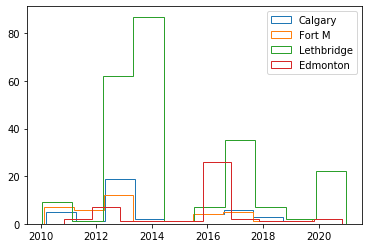

In [70]:
bins = np.linspace(-60, 40, 50)
plt.hist(yyc_na["FULL_BEGIN_DATE_GMT"], 
         histtype= 'step', label='Calgary')
plt.hist(fmm_na["FULL_BEGIN_DATE_GMT"],  
         histtype= 'step', label='Fort M')
plt.hist(lb_na["FULL_BEGIN_DATE_GMT"],  
         histtype= 'step', label='Lethbridge')
plt.hist(edm_na["FULL_BEGIN_DATE_GMT"], 
         histtype= 'step', label='Edmonton')
plt.legend(loc='upper right')
plt.show()

In [72]:
from collections import deque

def time_gap( next_gap, current):
    return (next_gap - current) / pd.Timedelta(hours=1)

def bfill_temperature(na_df,full_df):
    na_df["NEXT_GAP"] =  na_df["FULL_BEGIN_DATE_GMT"].shift(-1)
    na_df["PREV_GAP"] =  na_df["FULL_BEGIN_DATE_GMT"].shift(1)
    BFILL_TEMP_CELSIUS = pd.Series.copy(full_df["TEMP_CELSIUS"])
    series = deque()
    for index, row in na_df.iterrows():
        prev_gap = time_gap(row["FULL_BEGIN_DATE_GMT"], row["PREV_GAP"])
        next_gap= time_gap(row["NEXT_GAP"], row["FULL_BEGIN_DATE_GMT"])
        if prev_gap == 1.0 or next_gap == 1.0:
            last_day_temp = full_df[full_df["FULL_BEGIN_DATE_GMT"] == row["FULL_BEGIN_DATE_GMT"]-pd.Timedelta(days=1)]["TEMP_CELSIUS"]
            BFILL_TEMP_CELSIUS[index] = last_day_temp
        else:
            last_hour_temp = full_df[full_df["FULL_BEGIN_DATE_GMT"] == row["FULL_BEGIN_DATE_GMT"]-pd.Timedelta(hours=1)]["TEMP_CELSIUS"]
            BFILL_TEMP_CELSIUS[index] = last_hour_temp
    full_df["BFILL_TEMP_CELSIUS"] = BFILL_TEMP_CELSIUS


bfill_temperature(yyc_na, yyc_temp_full)
bfill_temperature(fmm_na, fort_temp_full)
bfill_temperature(lb_na,lethbridge_temp_full)
bfill_temperature(edm_na, edmonton_temp_full)


In [128]:
# 2: Lethbridge
# 6: Calgary
# 11: Edmonton
# 16: Fort McMurray

def fill_aux_data(df, stream_name, region):
    df["BEGIN_DATE_GMT"] = df["FULL_BEGIN_DATE_GMT"]
    df["END_DATE_GMT"] = df["BEGIN_DATE_GMT"] + pd.Timedelta(hours = 1)
    df["Region"] = np.repeat(region, df.shape[0])
    df.fillna({'SOURCE_TIMEZONE': "MST", 'NRG_STREAM_NAME': stream_name})
    return df[df.columns.difference(["FULL_BEGIN_DATE_GMT","SOURCE_DATETIME"])]

yyc_temp_final = fill_aux_data(yyc_temp_full, "EC - Calgary Temp", "6")
fort_temp_final = fill_aux_data(fort_temp_full, "EC - Fort McMurray Temp", "16")
lethbridge_temp_final = fill_aux_data(lethbridge_temp_full, "EC - Lethbridge Temp", "2")
edmonton_temp_final = fill_aux_data(edmonton_temp_full, "EC - Edmonton Temp", "11")

In [74]:
lethbridge_temp_final.head()

,BEGIN_DATE_GMT,BFILL_TEMP_CELSIUS,END_DATE_GMT,NRG_STREAM_NAME,Region,SOURCE_TIMEZONE,TEMP_CELSIUS
0,2010-01-01 07:00:00,-19.9,2010-01-01 08:00:00,EC - Lethbridge Temp,2,MST,-19.9
1,2010-01-01 08:00:00,-19.1,2010-01-01 09:00:00,EC - Lethbridge Temp,2,MST,-19.1
2,2010-01-01 09:00:00,-18.0,2010-01-01 10:00:00,EC - Lethbridge Temp,2,MST,-18.0
3,2010-01-01 10:00:00,-17.3,2010-01-01 11:00:00,EC - Lethbridge Temp,2,MST,-17.3
4,2010-01-01 11:00:00,-16.0,2010-01-01 12:00:00,EC - Lethbridge Temp,2,MST,-16.0


In [49]:
with pd.ExcelWriter('cleaned data/Temps Data Back Filled.xlsx') as writer:  
    yyc_temp_final.to_excel(writer, sheet_name='Calgary')
    fort_temp_final.to_excel(writer, sheet_name='Fort McMurray')
    lethbridge_temp_final.to_excel(writer, sheet_name='Lethbridge')
    edmonton_temp_final.to_excel(writer, sheet_name='Edmonton')

In [32]:
# Reading in population data
pop_low_growth = pd.read_csv("original data/2020-2046-05-census-divisions-population-projections-low.csv",
                            dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_med_growth = pd.read_csv("original data/2020-2046-07-census-divisions-population-projections-medium.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_high_growth = pd.read_csv("original data/2020-2046-09-census-divisions-population-projections-high.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

In [33]:
pop_full = pd.DataFrame(data = {"Year": pop_low_growth["Year"],
                               "Region": pop_low_growth["Region"],
                                "Sex": pop_low_growth["Sex"],
                                "Age": pop_low_growth["Age"],
                               "pop_low": pop_low_growth["Pop"],
                               "pop_medium": pop_med_growth["Pop"],
                                "pop_high": pop_high_growth["Pop"]
                               })

cd_divisions = ["2","6","11","16"]
# 2: Lethbridge
# 6: Calgary
# 11: Edmonton
# 16: Fort McMurray

def base_filter(df):
    period = (df["Year"] >= 2010)
    in_4_metros = df["Region"].apply(lambda x: x in cd_divisions)
    conditions = period & in_4_metros & (df["Sex"] == "3") & (df["Age"] =="Total")
              
    return df[conditions][df.columns.difference(["Sex","Age"])]

pop_metros =  base_filter(pop_full)


In [106]:
def gen_pop_pct(pop_df, pop_col ):
    pop_by_year =  pop_df.groupby(['Year','Region']).agg({pop_col: 'sum'})
    pop_pct = pop_by_year.groupby(level=0).apply(lambda x: x / float(x.sum()))
    return pop_pct.reset_index()

pop_metros_sorted = pop_metros.sort_values(["Year", "Region"])

for pop_col in ["pop_high","pop_low","pop_medium"]:
    pop_pct = gen_pop_pct(pop_metros_sorted, pop_col).sort_values(["Year", "Region"])
    pop_metros_sorted["pct_"+pop_col]  = [pct for pct in pd.Series.copy(pop_pct[pop_col])]

In [113]:
pop_metros_sorted.columns

Index(['Region', 'Year', 'pop_high', 'pop_low', 'pop_medium', 'pct_pop_high',
       'pct_pop_low', 'pct_pop_medium'],
      dtype='object')

In [135]:
pop_metros_sorted.to_excel("cleaned data/Population 2010-2046.xls")

In [110]:
# Combining temperature and population
temps_final = [yyc_temp_final, fort_temp_final, lethbridge_temp_final , edmonton_temp_final]
pop_cols = ["pop_high","pop_low","pop_medium"]

def merge_population(temp_df, pop_df):
    return temp_df.merge(pop_metros, on = ['Year','Region'], how = 'left')

def gen_weighted_temp(temp_df, temp_col, pop_df, pop_col):
    pop_pct = gen_pop_pct(pop_df, pop_col)
    temp_df["Year"] =  [begin_time.year for begin_time in temp_df["BEGIN_DATE_GMT"]]
    weighted_temp = temp_df.merge(pop_pct, on = ['Year','Region'], how = 'left')
    weighted_temp[temp_col + "_weighted_"+pop_col] = weighted_temp[temp_col] * weighted_temp["pct_"+pop_col]
    return weighted_temp

In [133]:
temps_final = pd.concat([yyc_temp_final, fort_temp_final, lethbridge_temp_final , edmonton_temp_final])
temps_final["Year"] = [begin_time.year for begin_time in temps_final["BEGIN_DATE_GMT"]]
weighted_temp = temps_final.merge(pop_metros_sorted, on = ['Year','Region'], how = 'left')

temp_col = "BFILL_TEMP_CELSIUS"
for pop_col in ["pop_high","pop_low","pop_medium"]:
    weighted_temp[temp_col.replace("_TEMP_CELSIUS","") + "_weighted_"+pop_col] = weighted_temp[temp_col] * weighted_temp["pct_"+pop_col]

In [134]:
weighted_temp.sort_values(["BEGIN_DATE_GMT","Region"], inplace = True)
weighted_temp.rename(str.upper, axis='columns', inplace = True)
weighted_temp.head()

,BEGIN_DATE_GMT,BFILL_TEMP_CELSIUS,END_DATE_GMT,NRG_STREAM_NAME,REGION,SOURCE_TIMEZONE,TEMP_CELSIUS,YEAR,POP_HIGH,POP_LOW,POP_MEDIUM,PCT_POP_HIGH,PCT_POP_LOW,PCT_POP_MEDIUM,BFILL_WEIGHTED_POP_HIGH,BFILL_WEIGHTED_POP_LOW,BFILL_WEIGHTED_POP_MEDIUM
289587,2010-01-01 07:00:00,-24.3,2010-01-01 08:00:00,EC - Edmonton Temp,11,MST,-24.3,2010,1227854,1227854,1227854,0.439387,0.439387,0.439387,-10.677110,-10.677110,-10.677110
96529,2010-01-01 07:00:00,-30.5,2010-01-01 08:00:00,EC - Fort McMurray Temp,16,MST,-30.5,2010,67824,67824,67824,0.024271,0.024271,0.024271,-0.740259,-0.740259,-0.740259
193058,2010-01-01 07:00:00,-19.9,2010-01-01 08:00:00,EC - Lethbridge Temp,2,MST,-19.9,2010,160510,160510,160510,0.057438,0.057438,0.057438,-1.143025,-1.143025,-1.143025
0,2010-01-01 07:00:00,-21.7,2010-01-01 08:00:00,EC - Calgary Temp,6,MST,-21.7,2010,1338281,1338281,1338281,0.478904,0.478904,0.478904,-10.392206,-10.392206,-10.392206
289588,2010-01-01 08:00:00,-24.0,2010-01-01 09:00:00,EC - Edmonton Temp,11,MST,-24.0,2010,1227854,1227854,1227854,0.439387,0.439387,0.439387,-10.545294,-10.545294,-10.545294


In [144]:
weighted_temp.reindex().to_csv("cleaned data/Weighted Temp 2010-2021.csv")